In [425]:
import numpy as np
import pandas as pd
import openpyxl as op
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from datetime import date

In [426]:
data = pd.read_csv("tumor_growth.csv")
# find the times each mouse shows up
valid_mice = []
for mouse in data['Mice identification'].value_counts().index[:10]:
    valid_mice.append(mouse)
# only keep the valid mice
data = data[data['Mice identification'].isin(valid_mice)]
data.reset_index(inplace=True)
# delete the old index column
del data['index']
data = data.sort_values(['Mice identification', 'Day after engraftment'], ascending=[True, True])
# include the volume column in the dataframe
data['Volume'] =  data['Length (mm)'] * data['Width (mm)'] * data['Height (mm)'] #formula 2

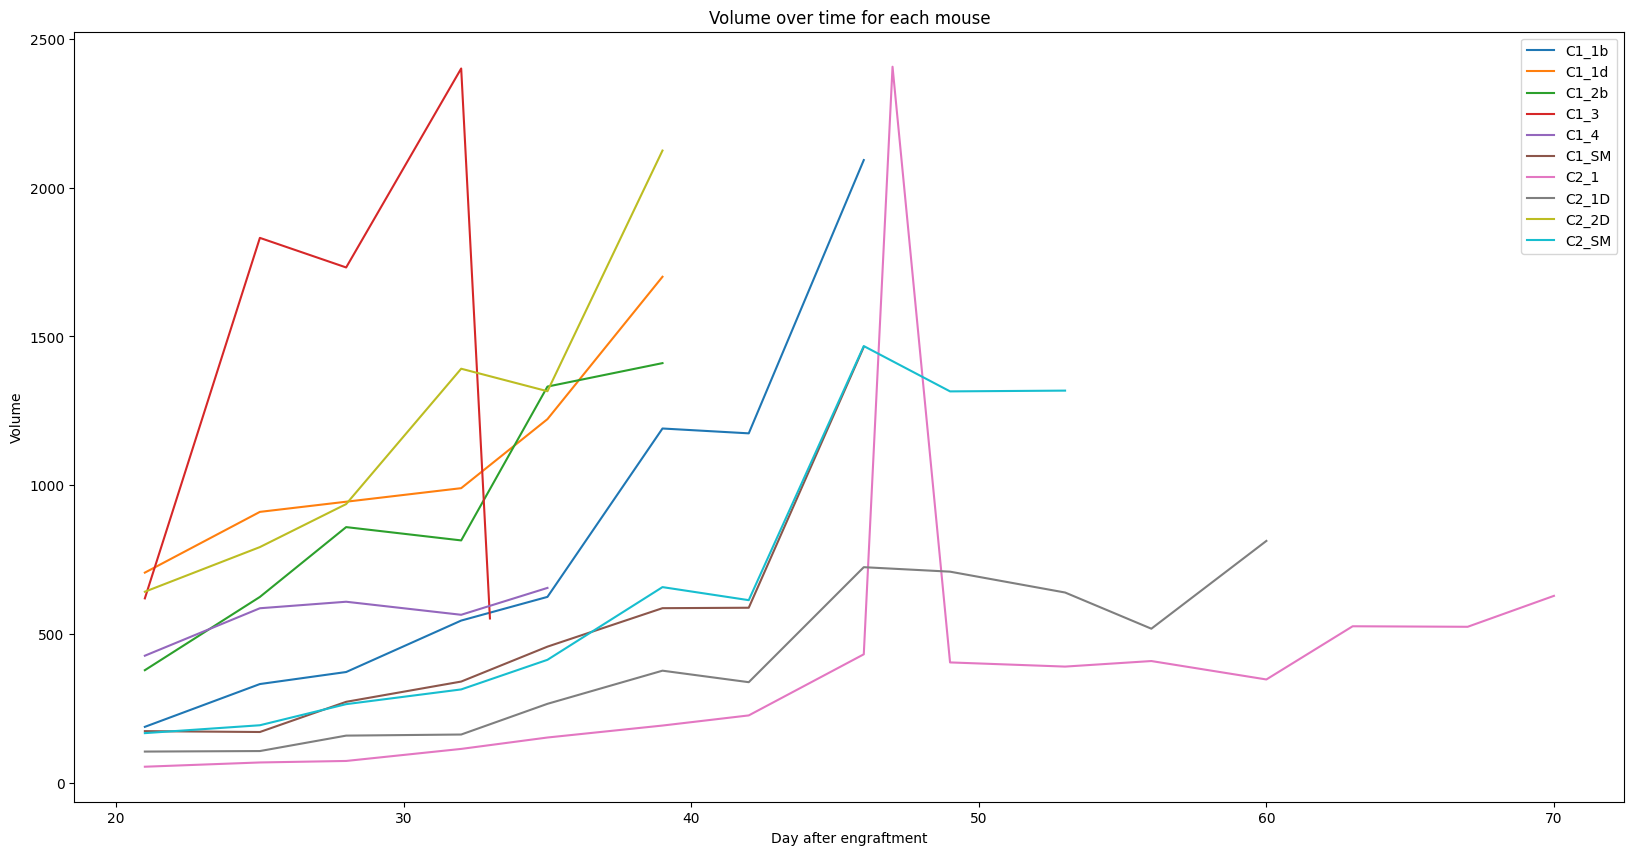

In [427]:
plt.figure(figsize=(20,10))
for mouse in data['Mice identification'].unique():
    plt.plot(data[data['Mice identification']==mouse]['Day after engraftment'], data[data['Mice identification']==mouse]['Volume'], label=mouse)
plt.legend()
plt.xlabel('Day after engraftment')
plt.ylabel('Volume')
plt.title('Volume over time for each mouse')
plt.show()

In [428]:
class TransgenicMouseData:

    def __init__(self):
        self.wb = op.load_workbook('TransgenicMouseData.xlsx')
        self.mouse2exp = {self.wb['Main experiment summary']['B'+str(6+i)].value: [self.wb['Main experiment summary']['E'+str(6+i)].value, self.wb['Main experiment summary']['I'+str(6+i)].value] for i in range(0, 58)}
        self.mouse2data = dict()
        self.untreated_mice = list()
        self.treated_mice = list()
        self.__init__mouse_data()
    
    def __init__mouse_data(self):
        mouse2cell = dict()
        mouse_ids = set(self.mouse2exp.keys())
        for mouse_exp in self.mouse2exp.values():
            sheet = self.wb['Tumor sizes_' + mouse_exp[0]]
            for row in sheet.iter_rows(min_row=8, min_col=4, max_row=270, max_col=5, values_only=False):
                for cell in row:
                    if cell.value in mouse_ids:
                        mouse2cell[cell.value] = (cell.row, cell.column)
                        break

        for mouse_id, mouse_cell in mouse2cell.items():
            if mouse_id == 'CM.41':
                continue
            
            self.mouse2data[mouse_id] = dict()
            r, c = mouse_cell[0] + 2, mouse_cell[1]
            date_row = r-3
            sheet = self.wb['Tumor sizes_' + self.mouse2exp[mouse_id][0]]
            H, V, D = [], [], []
            while sheet.cell(r,c).value != None:
                # extract only Tumor 1 measurements 
                h, v = [], []
                for i in range(3):
                    measure_h = str(sheet.cell(r+i, c).value)
                    measure_v = str(sheet.cell(r+3+i, c).value)
                    h.append(float(measure_h)) if '*' not in measure_h else h.append(float(measure_h[:-1]))
                    v.append(float(measure_v)) if '*' not in measure_v else v.append(float(measure_v[:-1]))
    
                d = (str(sheet.cell(date_row, c).value)).split("/")
                day, month = int(d[0] if d[0]!=0 else d[0][-1]), int(d[1] if d[1]!=0 else d[1][-1])
                D.append(date(2012, month, day))

                H.append(np.median(h))
                V.append(np.median(v))
                
                c += 1
       
            H = np.array(H)
            V = np.array(V)
            
            self.mouse2data[mouse_id]['Volume'] = np.pi/6 * np.power(np.multiply(H,V), 3/2)
            self.mouse2data[mouse_id]['Date'] = D

            if self.mouse2exp[mouse_id][1] == 'DMSO':
                self.untreated_mice.append(mouse_id)
        
            else:
                self.treated_mice.append(mouse_id)


In [429]:
mice = TransgenicMouseData()


/Users/veramazeeva/anaconda3/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [430]:
class TumorGrowth():

    def __init__(self, untreated_only=True):
        mice = TransgenicMouseData()
        self.mouse2data = dict((m, mice.mouse2data[m]) for m in mice.untreated_mice)

        if not untreated_only:
            self.mouse2data = mice.mouse2data
        
        for mouse_id in self.mouse2data.keys():
            self.mouse2data[mouse_id]['Day'] = [0]
            for i in range(1, len(self.mouse2data[mouse_id]['Date'])):
                self.mouse2data[mouse_id]['Day'] += [(self.mouse2data[mouse_id]['Date'][i] - self.mouse2data[mouse_id]['Date'][i-1]).days + self.mouse2data[mouse_id]['Day'][-1]]


        self.mouse2model = dict()
        self.__init__models()


    def __init__models(self):
        for mouse_id, mouse_data in self.mouse2data.items():
            self.mouse2model[mouse_id] = dict()
            self.mouse2model[mouse_id]['Logistic'] = self.fit_logistic(mouse_data['Volume']) #four sets of parameters --> FE, BE, LF, RK4
            self.mouse2model[mouse_id]['Gompertz'] = self.fit_gompertz(mouse_data['Volume'])
            self.mouse2model[mouse_id]['Bertalanffy'] = self.fit_bertalanffy(mouse_data['Volume'])
            
    def fit_logistic(sef, data):
        pass


    def fit_gompertz(self, data):
        
        def gompertz_growth(V, a, b):
            return a * V - b*V* np.log(V)

        def gompertz_fe(t, a, b):
            solution = np.zeros_like(t)
            solution[0] = data[0]
            for i in range(1, len(t)):
                solution[i] = solution[i-1] + gompertz_growth(solution[i-1], a, b)
            return solution
        
        def gompertz_lf(t, a, b):
            solution = np.zeros_like(t)
            solution[0] = data[0]
            solution[1] = solution[0] + gompertz_growth(solution[0], a, b)
            for i in range(2, len(t)):
                solution[i] = solution[i-2] + 2 * gompertz_growth(solution[i-1], a, b)
            return solution
        
        def gompertz_be(t, a, b): #TODO
            pass

        def gompertz_rk4(t, a, b):
            solution = np.zeros_like(t)
            solution[0] = data[0]
            for i in range(1, len(t)):
                prev = solution[i-1]
                k1 = gompertz_growth(prev, a, b)
                k2 = gompertz_growth(prev + k1/2, a, b)
                k3 = gompertz_growth(prev + k2/2, a, b)
                k4 = gompertz_growth(prev + k3, a, b)
                solution[i] = prev + (1/6) * (k1 + 2*k2 + 2*k3 + k4)
            return solution 
        
        guess = [0, 0]
        bounds = ([0, 0,], [np.inf, np.inf])
        
        params_fe, _ = curve_fit(gompertz_fe, [i for i in range(len(data))], data, p0=guess, bounds=bounds, maxfev=20000)
        params_lf, _ = curve_fit(gompertz_lf, [i for i in range(len(data))], data, p0=guess, bounds=bounds, maxfev=20000)
        params_be, _ = [], [] # TODO
        params_rk4, _ = curve_fit(gompertz_rk4, [i for i in range(len(data))], data, p0=guess, bounds=bounds, maxfev=20000)

        N = len(data)

        return {'params': [params_fe, params_lf, params_be, params_rk4], 'nmse': []}

    def fit_bertalanffy(self, data):
        pass

    def plot(self, mouse_id): # Use analytical solution of ODE for plotting fitted model curve

        def RK4_scheme(f, x0, t0, tf,  N, params):
            solution = [x0]
            h = (tf - t0)/N
            for n in range(N):
                prev = solution[-1]
                k1 = h * f(prev, params)
                k2 = h * f(prev + k1/2, params)
                k3 = h * f(prev + k2/2, params)
                k4 = h * f(prev + k3, params)
                solution += [prev + (1/6) * (k1 + 2*k2 + 2*k3 + k4)]
            return solution
        
        def gompertz_growth(V, params):
            (a, b) = params
            return a * V - b*V* np.log(V)
        
        

        def gompertz_soln(t, V0, a, b):
            return V0 * np.exp((a/b) * (1 - np.exp(-b*t)))
        
        a, b = self.mouse2model[mouse_id]['Gompertz'][1]

     

        t1 = [i for i in range(len(self.mouse2data[mouse_id]['Volume'])+1)]
        s1 = RK4_scheme(gompertz_growth, self.mouse2data[mouse_id]['Volume'][0], 0, len(self.mouse2data[mouse_id]['Volume']),  len(self.mouse2data[mouse_id]['Volume']), self.mouse2model[mouse_id]['Gompertz'][1])
        t2 = [i for i in range(len(self.mouse2data[mouse_id]['Volume']))]

        s2 = [gompertz_soln(t2[i], self.mouse2data[mouse_id]['Volume'][0], a, b) for i in range(len(self.mouse2data[mouse_id]['Volume']))]

        plt.plot(t1, s1)
        plt.plot(t2, self.mouse2data[mouse_id]['Volume'])
        #plt.plot(t2, s2)
        

In [433]:
models = TumorGrowth()
models.mouse2model['CM.37']

/Users/veramazeeva/anaconda3/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


{'Logistic': None,
 'Gompertz': {'params': [array([0.91749877, 0.1452483 ]),
   array([0.79541935, 0.12349902]),
   [],
   array([0.77492952, 0.11985168])],
  'nmse': []},
 'Bertalanffy': None}

In [432]:
models.plot('CM.78')

KeyError: 1

In [ ]:
models.mouse2model

{'CM.37': {'Logistic': None,
  'Gompertz': [array([2.42925825e-03, 1.57436185e+55]),
   array([2.13085411e-03, 3.14872371e+55]),
   []],
  'Bertalanffy': None},
 'CM.38': {'Logistic': None,
  'Gompertz': [array([1.79707744e-03, 5.90198875e+54]),
   array([1.61151132e-03, 2.76743550e+55]),
   []],
  'Bertalanffy': None},
 'CM.53': {'Logistic': None,
  'Gompertz': [array([5.20334743e-04, 6.14129295e+53]),
   array([5.03881737e-04, 7.09546799e+53]),
   []],
  'Bertalanffy': None},
 'CM.76': {'Logistic': None,
  'Gompertz': [array([7.25213736e-04, 7.88533401e+53]),
   array([6.95158868e-04, 7.88533401e+53]),
   []],
  'Bertalanffy': None},
 'CM.77': {'Logistic': None,
  'Gompertz': [array([2.06586340e-03, 1.51041535e+17]),
   array([1.75751949e-03, 3.40241178e+19]),
   []],
  'Bertalanffy': None},
 'CM.78': {'Logistic': None,
  'Gompertz': [array([1.59786181e-03, 7.73273529e+54]),
   array([1.43279158e-03, 1.29402492e+56]),
   []],
  'Bertalanffy': None},
 'CM.79': {'Logistic': None,
  'Go

<Axes: xlabel='Time point', ylabel='Tumor volume '>

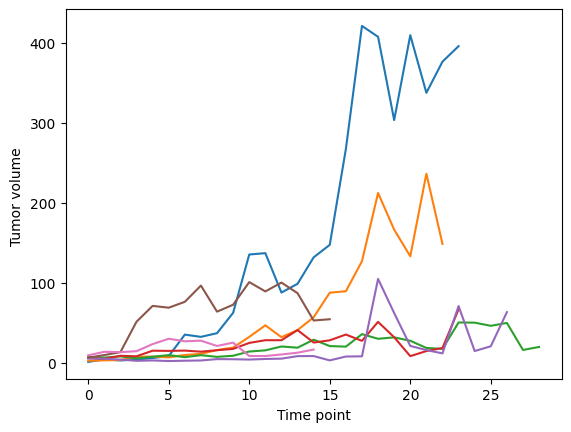

In [ ]:
treated = dict((m, mice.mouse2data[m]['Volume']) for m in mice.untreated_mice)

df = pd.concat([pd.DataFrame(v, columns=[k]) for k, v in treated.items()], axis=1)

df.plot(kind='line', legend=False, xlabel="Time point", ylabel="Tumor volume ")

In [ ]:
def gompertz_growth(V, V0, params):
    (tau, theta) = params
    return 1/tau * np.log(np.log(theta/V0)/np.log(theta/(2*V0))) * V * np.log(theta/V)

def RK4_scheme(f, x0, t0, tf,  N, params):
    solution = [x0]
    h = (tf - t0)/N
    for n in range(N):
        prev = solution[-1]
        k1 = h * f(prev, solution[0], params)
        k2 = h * f(prev + k1/2, solution[0], params)
        k3 = h * f(prev + k2/2, solution[0], params)
        k4 = h * f(prev + k3, solution[0], params)
        solution += [prev + (1/6) * (k1 + 2*k2 + 2*k3 + k4)]
    return solution

In [ ]:
def gompertz_model(t, tau, theta):
    V0 = mice.untreated_mice['CM.37'][0]

    def gompertz_growth(V, V0, tau, theta):
        return 1/tau * np.log(np.log(theta/V0)/np.log(theta/(2*V0))) * V * np.log(theta/V)

    solution = np.zeros_like(t)
    solution[0] = V0

    for i in range(1, len(t)):
        prev = solution[i-1]
        k1 = gompertz_growth(prev, V0, tau, theta)
        k2 = gompertz_growth(prev + k1/2, V0, tau, theta)
        k3 = gompertz_growth(prev + k2/2, V0, tau, theta)
        k4 = gompertz_growth(prev + k3, V0, tau, theta)
        solution[i] = prev + (1/6) * (k1 + 2*k2 + 2*k3 + k4)

    return solution 



In [ ]:
initial_guesses = [2, max(mice.untreated_mice['CM.37'])]
bounds = ([0, 0,], [np.inf, np.inf])
params, _ = curve_fit(gompertz_model, [i for i in range(len(mice.untreated_mice['CM.37']))], mice.untreated_mice['CM.37'], p0=initial_guesses, bounds=bounds)

In [ ]:
params

array([  0.95239938, 642.73706699])

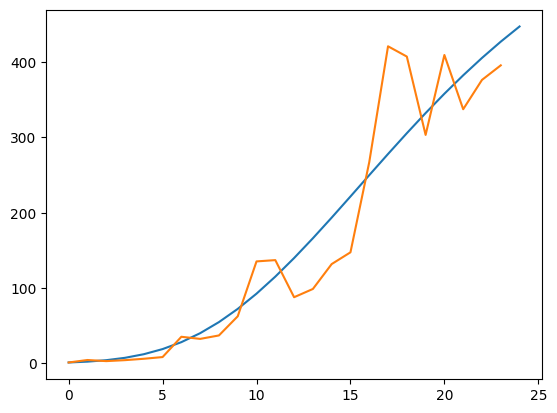

In [ ]:
s = RK4_scheme(gompertz_growth, mice.untreated_mice['CM.37'][0], 0, len(mice.untreated_mice['CM.37']),  len(mice.untreated_mice['CM.37']), params)

plt.plot([i for i in range(len(mice.untreated_mice['CM.37'])+1)], s)
plt.plot([i for i in range(len(mice.untreated_mice['CM.37']))], mice.untreated_mice['CM.37'])

[ 0.59099851 81.22001302]


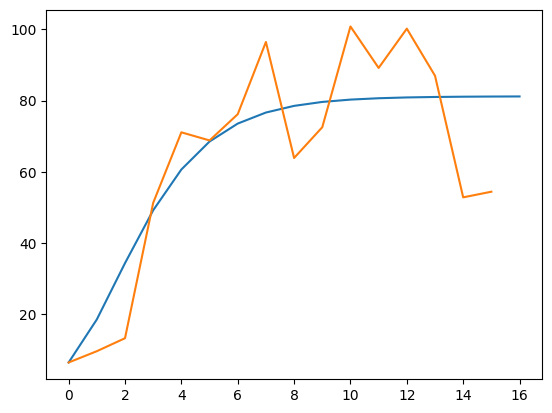

In [ ]:
mouse = 'CM.78'

def gompertz_model(t, tau, theta):
    V0 = mice.untreated_mice[mouse][0]

    def gompertz_growth(V, V0, tau, theta):
        return 1/tau * np.log(np.log(theta/V0)/np.log(theta/(2*V0))) * V * np.log(theta/V)

    solution = np.zeros_like(t)
    solution[0] = V0

    for i in range(1, len(t)):
        prev = solution[i-1]
        k1 = gompertz_growth(prev, V0, tau, theta)
        k2 = gompertz_growth(prev + k1/2, V0, tau, theta)
        k3 = gompertz_growth(prev + k2/2, V0, tau, theta)
        k4 = gompertz_growth(prev + k3, V0, tau, theta)
        solution[i] = prev + (1/6) * (k1 + 2*k2 + 2*k3 + k4)

    return solution 

initial_guesses = [2, max(mice.untreated_mice[mouse])]
bounds = ([0, 0,], [np.inf, np.inf])
params, _ = curve_fit(gompertz_model, [i for i in range(len(mice.untreated_mice[mouse]))], mice.untreated_mice[mouse], p0=initial_guesses, bounds=bounds)

print(params)

s = RK4_scheme(gompertz_growth, mice.untreated_mice[mouse][0], 0, len(mice.untreated_mice[mouse]),  len(mice.untreated_mice[mouse]), params)

plt.plot([i for i in range(len(mice.untreated_mice[mouse])+1)], s)
plt.plot([i for i in range(len(mice.untreated_mice[mouse]))], mice.untreated_mice[mouse])

In [ ]:
data[data['Mice identification']==mouse]['Volume'].values

array([ 188.08425 ,  331.89912 ,  372.32079 ,  545.210502,  624.792186,
       1190.622576, 1174.330872, 2092.64256 ])

[1.72187817e+00 2.29374927e+59]


/Users/veramazeeva/anaconda3/lib/python3.10/site-packages/scipy/optimize/_lsq/common.py:115: RuntimeWarning: divide by zero encountered in divide
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm


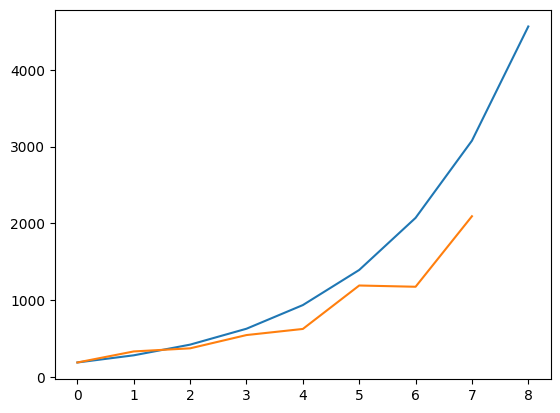

In [ ]:
mouse = 'C1_1b'

def gompertz_model(t, tau, theta):
    V0 = data[data['Mice identification']==mouse]['Volume'].values[0]

    def gompertz_growth(V, V0, tau, theta):
        return 1/tau * np.log(np.log(theta/V0)/np.log(theta/(2*V0))) * V * np.log(theta/V)

    solution = np.zeros_like(t)
    solution[0] = V0

    for i in range(1, len(t)):
        prev = solution[i-1]
        solution[i] = prev + gompertz_growth(prev, V0, tau, theta)

    return solution 

v = data[data['Mice identification']==mouse]['Volume'].values
v0 = data[data['Mice identification']==mouse]['Volume'].values[0]
t = len(data[data['Mice identification']==mouse]['Volume'].values)

initial_guesses = [1, max(v)]
bounds = ([0, 0,], [np.inf, np.inf])
params, _ = curve_fit(gompertz_model, [i for i in range(t)], v, p0=initial_guesses, bounds=bounds, maxfev=20000)

print(params)



s = RK4_scheme(gompertz_growth, v0, 0, t,  t, params)

plt.plot([i for i in range(t+1)], s)
plt.plot([i for i in range(t)], v)

[2.04522555e+00 2.14395132e+61]


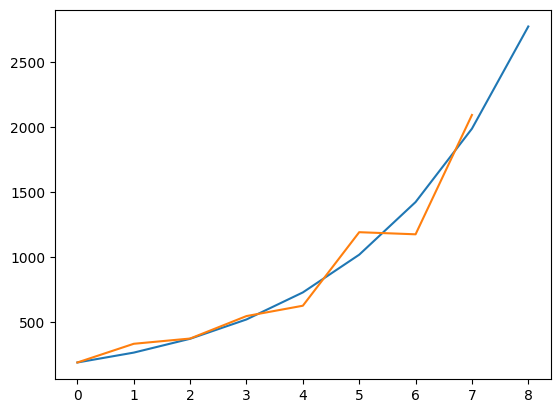

In [ ]:
mouse = 'C1_1b'

def gompertz_model(t, tau, theta):
    V0 = data[data['Mice identification']==mouse]['Volume'].values[0]

    def gompertz_growth(V, V0, tau, theta):
        return 1/tau * np.log(np.log(theta/V0)/np.log(theta/(2*V0))) * V * np.log(theta/V)

    solution = np.zeros_like(t)
    solution[0] = V0

    for i in range(1, len(t)):
        prev = solution[i-1]
        k1 = gompertz_growth(prev, V0, tau, theta)
        k2 = gompertz_growth(prev + k1/2, V0, tau, theta)
        k3 = gompertz_growth(prev + k2/2, V0, tau, theta)
        k4 = gompertz_growth(prev + k3, V0, tau, theta)
        solution[i] = prev + (1/6) * (k1 + 2*k2 + 2*k3 + k4)

    return solution 

v = data[data['Mice identification']==mouse]['Volume'].values
v0 = data[data['Mice identification']==mouse]['Volume'].values[0]
t = len(data[data['Mice identification']==mouse]['Volume'].values)

initial_guesses = [1, max(v)]
bounds = ([0, 0,], [np.inf, np.inf])
params, _ = curve_fit(gompertz_model, [i for i in range(t)], v, p0=initial_guesses, bounds=bounds, maxfev=20000)

print(params)



s = RK4_scheme(gompertz_growth, v0, 0, t,  t, params)

plt.plot([i for i in range(t+1)], s)
plt.plot([i for i in range(t)], v)

In [435]:
A = [1,2,3,4,5,6,7]
A[:3]

[1, 2, 3]